Refactored OOP

# Import Dependencies

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import gc
import glob
import os

import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style('white')

from tqdm import tqdm, tqdm_notebook
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model, save_model
from keras.layers import Input, Dropout, BatchNormalization, Activation, Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers

Using TensorFlow backend.


# Define SaltParser

In [3]:
class SaltParser(object):

    '''
    Parser for Salt Competition.
    '''

    def __init__(self, data_src,img_size_ori, img_size_target):

        self.data_src = data_src
        self.img_size_ori = img_size_ori
        self.img_size_target = img_size_target
        
        self.train_df = None
        self.test_df = None

        self.X_train = []
        self.y_train = []
        self.X_test = []
        

    def load_csv_data(self):
        
        '''
        Initialize processing by loading .csv files.
        After loading, train_df and test_df will have column 'id' for each unique image id
        and 'z' for depth
        '''

        train_df = pd.read_csv(f'{self.data_src}train.csv', usecols=[0], index_col='id')
        depths_df = pd.read_csv(f'{self.data_src}depths.csv', index_col='id')
        self.train_df = train_df.join(depths_df)
        self.test_df = depths_df[~depths_df.index.isin(train_df.index)]

        return

    
    def load_img_data(self):
        
        '''
        Load images and masks from training set. Can only be executed after load_csv_data()
        
        # Returns:
            self.X_train: np.array of training images
            self.y_train: np.array of training masks
            self.X_test: np.array of test images
        '''

        print("Loading training images...")
        self.X_train = [np.array(cv2.imread(f"{self.data_src}train/images/{idx}.png", 0)) for idx in tqdm_notebook(self.train_df.index)]
        self.X_train = np.expand_dims(self.X_train, -1)
        print(f'X_train shape: {self.X_train.shape}')
        print(f'X_train - min: {np.min(self.X_train)}, max: {np.max(self.X_train)}')
        
        print("\n\nLoading training masks...")
        self.y_train = [np.array(cv2.imread(f"{self.data_src}train/masks/{idx}.png", 0)) for idx in tqdm_notebook(self.train_df.index)]
        self.y_train = np.expand_dims(self.y_train, -1)
        print(f'y_train shape: {self.y_train.shape}')
        print(f'y_train - min: {np.min(self.y_train)}, max: {np.max(self.y_train)}')

        print("\n\nLoading test images...")
        self.X_test = [np.array(cv2.imread(f"{self.data_src}test/images/{idx}.png", 0)) for idx in tqdm_notebook(self.test_df.index)]
        self.X_test = np.expand_dims(self.X_test, -1)  
        print(f'X_test shape: {self.X_test.shape}')
        print(f'X_test - min: {np.min(self.X_test)}, max: {np.max(self.X_test)}')

        return self.X_train, self.y_train, self.X_test
    
    
    def process_img(self, data, normalized=False, image_resized_size=None, padding=None):
        scale = 1
        if normalized:
            scale = 1 / 255.
            
        data_proc = data * scale
        data_proc_list = []
        
        for i in tqdm_notebook(range(data_proc.shape[0])):
            img_tmp = data_proc[i,:,:,0]

            if image_resized_size:
                img_tmp = cv2.resize(img_tmp, image_resized_size)

            if padding:
                img_tmp = cv2.copyMakeBorder(img_tmp, padding, padding, padding, padding,
                                             cv2.BORDER_REFLECT_101)
            data_proc_list.append(img_tmp)
            
        data_proc = np.expand_dims(data_proc_list, -1)          
            
        print(f'Processed data shape: {data_proc.shape}')
        print(f'Processed data - min: {np.min(data_proc)}, max: {np.max(data_proc)}')
        
        return data_proc
    

    def compute_coverage(self):
        
        '''
        Compute salt coverage of each mask. This will serve as a basis for 
        stratified split between training and validation sets.
        
        # Returns:
            self.train_df: training DF containing coverage information.
        '''

        print('Compute mask coverage for each observation.')
        self.train_df['coverage'] = np.mean(self.y_train / 255., axis=(1, 2))
        self.train_df["coverage_class"] = self.train_df.coverage.apply(lambda val: np.int(np.ceil(val*10)))

        return self.train_df

    def predictions_rle_encode(self, y_pred_test, confidence_threshold_best):
        
        '''
        Run Length Encoding of predictions.
        This is needed for submission output.
        
        # Arguments:
            y_pred_test: model predictions
            confidence_threshold_best: confidence threshold, according to which
                masks are set to 1/0.
        # Returns:
            y_test_pred_rle: RLEncoded predictions.
        '''

        # Remove padding
        print('Remove padding from images.')
        y_pred_test = y_pred_test[:, 11:-11, 11:-11, 0]
            
        # Resize back to original size
        y_pred_test = np.asarray([cv2.resize(x, self.img_size_ori) for x in y_pred_test])

        assert y_pred_test.shape == (18000, 101, 101), '\
        Test predictions shape must be equal to (18000, 101, 101).'

        print('Test predictions shape: {}'.format(y_pred_test.shape))

        # Perform mask predictions binarization and RLEncoding. 
        y_test_pred_rle = {idx:
                           rle_encode(y_pred_test[i] > confidence_threshold_best)
                           for i, idx in enumerate(
                               tqdm(self.test_df.index.values))}

        return y_test_pred_rle

    def generate_submission(self, y_test_pred_rle):
        
        '''
        Submission generation based on encoded model predictions.
        
        # Arguments:
            y_test_pred_rle: RLEncoded predictions.
        # Returns:
            submission: generated submission.
        '''

        submission = pd.DataFrame.from_dict(y_test_pred_rle, orient='index')
        submission.index.names = ['id']
        submission.columns = ['rle_mask']

        return submission

## Define helper functions

In [4]:
# Quick RLEncoding needed for submission generation.
# Source: another kernel, thanks!
def rle_encode(im):
    '''
    im: numpy array, 1-mask, 0-background
    Returns run length as string
    '''
    pixels = im.flatten(order='F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## Initialize parameters

In [5]:
salt_parser = SaltParser(data_src='data/salt/', 
                         img_size_ori=(101,101), 
                         img_size_target=(224,224))

## Initialize and load data

In [6]:
salt_parser.load_csv_data()
X_train, y_train, X_test = salt_parser.load_img_data()

Loading training images...



X_train shape: (4000, 101, 101, 1)
X_train - min: 0, max: 255


Loading training masks...



y_train shape: (4000, 101, 101, 1)
y_train - min: 0, max: 255


Loading test images...



X_test shape: (18000, 101, 101, 1)
X_test - min: 0, max: 255


## Salt coverage

In [10]:
train_df = salt_parser.compute_coverage()

Compute mask coverage for each observation.


Text(0.5, 0, 'Coverage class')

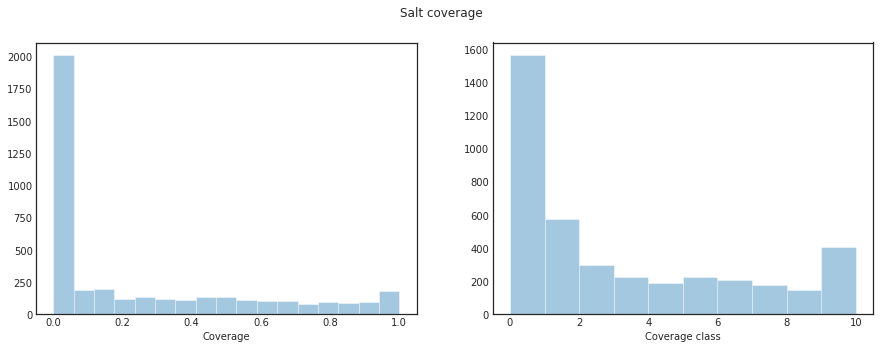

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

## Depth

Text(0.5, 1.0, 'Depth distribution')

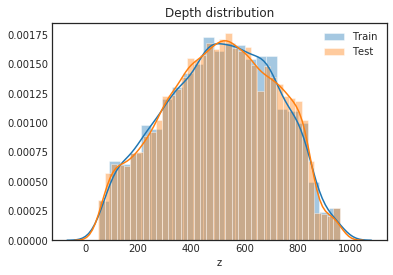

In [12]:
sns.distplot(salt_parser.train_df.z, label="Train")
sns.distplot(salt_parser.test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

## Process raw images by normalization, scaling and padding

In [40]:
X_train_proc = salt_parser.process_img(salt_parser.X_train, normalized=True, image_resized_size=(202,202), padding=11)
y_train_proc = salt_parser.process_img(salt_parser.y_train, normalized=True, image_resized_size=(202,202), padding=11)
X_test_proc = salt_parser.process_img(salt_parser.X_test, normalized=True, image_resized_size=(202,202), padding=11)


Processed data shape: (4000, 224, 224, 1)
Processed data - min: 0.0, max: 1.0



Processed data shape: (4000, 224, 224, 1)
Processed data - min: 0.0, max: 1.0



Processed data shape: (18000, 224, 224, 1)
Processed data - min: 0.0, max: 1.0


In [41]:
X_train_proc = X_train_proc.astype(np.float32)
y_train_proc = y_train_proc.astype(np.float32)
X_test_proc = X_test_proc.astype(np.float32)

## Sanity Check

482


Text(0.5, 1.0, '2x-scaled image and reflected padding')

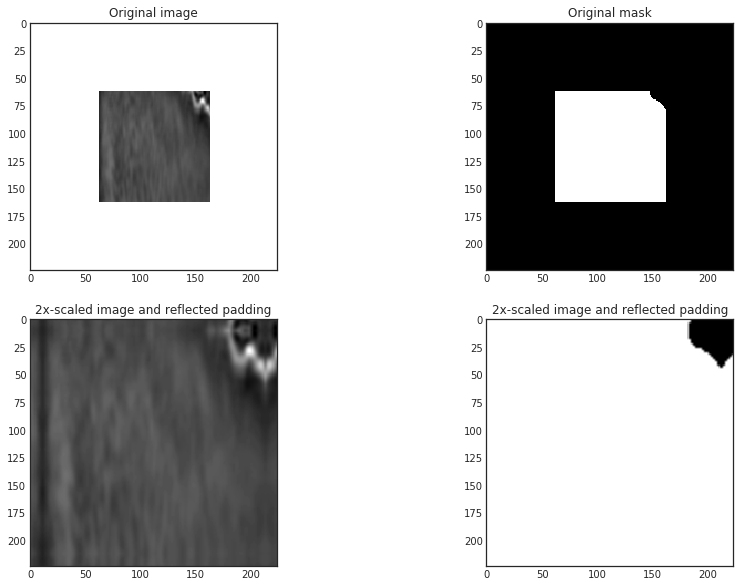

In [84]:
idx = np.random.randint(0,4000)
print(idx)

tmp_img = np.ones((224,224), dtype=np.float64)*255
tmp_mask = np.zeros((224,224), dtype=np.float64)

tmp_img[62:163, 62:163] = salt_parser.X_train[idx,:,:,0]
tmp_mask[62:163, 62:163] = salt_parser.y_train[idx,:,:,0]

fig, ax = plt.subplots(2, 2, figsize=(15,10))

ax[0,0].imshow(tmp_img, cmap="gray")
ax[0,0].set_title("Original image")
ax[0,1].imshow(tmp_mask, cmap="gray")
ax[0,1].set_title("Original mask")
ax[1,0].imshow(X_train_proc[idx].squeeze(), cmap="gray")
ax[1,0].set_title("2x-scaled image and reflected padding")
ax[1,1].imshow(y_train_proc[idx].squeeze(), cmap="gray")
ax[1,1].set_title("2x-scaled image and reflected padding")

# Perform stratified training/validation split based on coverage/depth

In [19]:
# Perform 80/20 training/validation split based on stratified coverage.
X_train, X_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    X_train_proc,
    y_train_proc,
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, 
    stratify=train_df.coverage_class, 
    random_state=1234)

del train_df
gc.collect()

del X_train_proc, y_train_proc
gc.collect()

0

In [136]:
len(y_train), y_train.shape

(3180, (3180, 224, 224, 1))

In [170]:
# boolean mask for mask with either all black pixel or at most 50 white pixels
thres = 30**2
y_mask = np.squeeze((y_train.sum(axis=(1,2))>=thres) | (y_train.sum(axis=(1,2))==0))

In [171]:
np.where(y_mask == False)

(array([  22,   27,   34,  107,  116,  180,  186,  199,  200,  230,  261,
         302,  324,  347,  371,  380,  397,  422,  441,  468,  470,  502,
         505,  564,  588,  594,  626,  636,  657,  668,  711,  766,  816,
         818,  829,  834,  859,  865,  884,  900,  933,  968, 1047, 1073,
        1141, 1144, 1206, 1230, 1236, 1237, 1258, 1290, 1291, 1326, 1337,
        1339, 1342, 1354, 1366, 1388, 1414, 1425, 1442, 1497, 1518, 1703,
        1710, 1771, 1799, 1802, 1835, 1887, 1898, 2033, 2050, 2094, 2120,
        2194, 2199, 2218, 2222, 2274, 2276, 2327, 2343, 2378, 2429, 2477,
        2483, 2484, 2501, 2521, 2535, 2565, 2598, 2622, 2629, 2639, 2657,
        2662, 2713, 2831, 2837, 2882, 2908, 2922, 2939, 2962, 2974, 3017,
        3033, 3035]),)

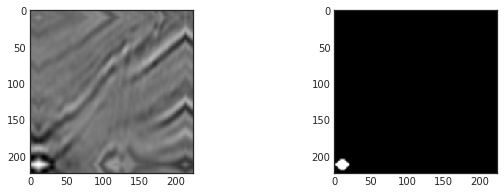

In [172]:
idx = 1703
fig, ax = plt.subplots(1, 2, figsize=(10,3))

ax[0].imshow(X_train[idx].squeeze(), cmap="gray")
ax[1].imshow(y_train[idx].squeeze(), cmap="gray")

In [173]:
len(y_train[y_mask])

3068

In [174]:
X_train = X_train[y_mask]
y_train = y_train[y_mask]

In [176]:
len(X_train), len(y_train)

(3068, 3068)

# Simple horizontal augmentation to double the data

In [177]:
X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

# Define UNet model

In [178]:
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation==True: x = BatchActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate=False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3))
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate: x = BatchActivate(x)
    return x

In [179]:
# Build Model
def build_model(input_layer, start_neurons, DropoutRatio=0.5):
    # 224 -> 112
    conv1 = Conv2D(start_neurons*1, (3,3), activation=None, padding='same')(input_layer)
    conv1 = residual_block(conv1, start_neurons*1)
    conv1 = residual_block(conv1, start_neurons*1, True)
    pool1 = MaxPooling2D((2,2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)
    
    # 112 -> 56
    conv2 = Conv2D(start_neurons*2, (3,3), activation=None, padding='same')(pool1)
    conv2 = residual_block(conv2, start_neurons*2)
    conv2 = residual_block(conv2, start_neurons*2, True)
    pool2 = MaxPooling2D((2,2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)
    
    # 56 -> 28
    conv3 = Conv2D(start_neurons*4, (3,3), activation=None, padding='same')(pool2)
    conv3 = residual_block(conv3, start_neurons*4)
    conv3 = residual_block(conv3, start_neurons*4, True)
    pool3 = MaxPooling2D((2,2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)
    
    # 28 -> 14
    conv4 = Conv2D(start_neurons*8, (3,3), activation=None, padding='same')(pool3)
    conv4 = residual_block(conv4, start_neurons*8)
    conv4 = residual_block(conv4, start_neurons*8, True)
    pool4 = MaxPooling2D((2,2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)
    
    # 14 -> 7
    conv5 = Conv2D(start_neurons*16, (3,3), activation=None, padding='same')(pool4)
    conv5 = residual_block(conv5, start_neurons*16)
    conv5 = residual_block(conv5, start_neurons*16, True)
    pool5 = MaxPooling2D((2,2))(conv5)
    pool5 = Dropout(DropoutRatio)(pool5)
    
    # Middle
    convm = Conv2D(start_neurons*32, (3,3), activation=None, padding='same')(pool5)
    convm = residual_block(convm, start_neurons*32)
    convm = residual_block(convm, start_neurons*32, True)
    
    # 7 -> 14
    deconv5 = Conv2DTranspose(start_neurons*16, (3,3), strides=(2,2), padding='same')(convm)
    uconv5 = concatenate([deconv5, conv5])
    uconv5 = Dropout(DropoutRatio)(uconv5)
    
    uconv5 = Conv2D(start_neurons*16, (3,3), activation=None, padding='same')(uconv5)
    uconv5 = residual_block(uconv5, start_neurons*16)
    uconv5 = residual_block(uconv5, start_neurons*16, True)
    
    # 14 -> 28
    deconv4 = Conv2DTranspose(start_neurons*8, (3,3), strides=(2,2), padding='same')(uconv5)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons*8, (3,3), activation=None, padding='same')(uconv4)
    uconv4 = residual_block(uconv4, start_neurons*8)
    uconv4 = residual_block(uconv4, start_neurons*8, True)
    
    # 28 -> 56
    deconv3 = Conv2DTranspose(start_neurons*4, (3,3), strides=(2,2), padding='same')(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons*4, (3,3), activation=None, padding='same')(uconv3)
    uconv3 = residual_block(uconv3, start_neurons*4)
    uconv3 = residual_block(uconv3, start_neurons*4, True)
    
    # 56 -> 112
    deconv2 = Conv2DTranspose(start_neurons*2, (3,3), strides=(2,2), padding='same')(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(DropoutRatio)(uconv2)
    
    uconv2 = Conv2D(start_neurons*2, (3,3), activation=None, padding='same')(uconv2)
    uconv2 = residual_block(uconv2, start_neurons*2)
    uconv2 = residual_block(uconv2, start_neurons*2, True)
    
    # 112 -> 224
    deconv1 = Conv2DTranspose(start_neurons*1, (3,3), strides=(2,2), padding='same')(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(DropoutRatio)(uconv1)
    
    uconv1 = Conv2D(start_neurons*1, (3,3), activation=None, padding='same')(uconv1)
    uconv1 = residual_block(uconv1, start_neurons*1)
    uconv1 = residual_block(uconv1, start_neurons*1, True)
    
    output_layer_noActi = Conv2D(1, (1,1), padding='same', activation=None)(uconv1)
    output_layer = Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

# Metric Loss

In [180]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))
        
    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

In [181]:
# code download from: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard

# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss

def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.elu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

In [182]:
def focal_loss(gamma=2., alpha=0.75):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, 1e-6, 1 - 1e-6)
        p_t = tf.where(tf.equal(y_true, 1), y_pred, 1. - y_pred)
        alpha_t = tf.where(tf.equal(y_true, 1), K.ones_like(y_pred) * K.constant(alpha), K.ones_like(y_pred) * K.constant(1. - alpha))
        loss = K.mean(-1. * alpha_t * (1. - p_t)**gamma * K.log(p_t))
        return loss
    return focal_loss_fixed

# Build Model

In [183]:
input_size = salt_parser.img_size_target[0]
input_layer = Input((input_size, input_size, 1))
output_layer = build_model(input_layer, 16, 0.5)

model1 = Model(input_layer, output_layer)

In [189]:
epochs = 50
batch_size = 32
opt = optimizers.Adam(lr=0.01)

model1.compile(loss="binary_crossentropy", optimizer=opt, metrics=[my_iou_metric])
# model1.compile(loss=[focal_loss(alpha=.75, gamma=2)], optimizer=c, metrics=[my_iou_metric])

# model1.summary()

In [190]:
save_model_name = 'unet_V4_1.model'

In [191]:
early_stopping = EarlyStopping(monitor='val_my_iou_metric', mode='max', patience=20, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name, monitor='val_my_iou_metric', mode='max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode='max', factor=0.5, patience=6, min_lr=0.00001, verbose=1)

# Train model:

In [192]:
%%time
history = model1.fit(X_train, y_train,
                     validation_data = [X_valid, y_valid], 
                     epochs = epochs, 
                     batch_size = batch_size, 
                     callbacks = [early_stopping, model_checkpoint, reduce_lr],
                     verbose = 1)

Train on 6136 samples, validate on 800 samples
Epoch 1/50
6136/6136 [==============================] - 329s 54ms/step - loss: 0.4934 - my_iou_metric: 0.3347 - val_loss: 2.0698 - val_my_iou_metric: 0.1688

Epoch 00001: val_my_iou_metric improved from -inf to 0.16875, saving model to unet_V4_1.model
Epoch 2/50
6136/6136 [==============================] - 308s 50ms/step - loss: 0.3937 - my_iou_metric: 0.4922 - val_loss: 1.1403 - val_my_iou_metric: 0.3900

Epoch 00002: val_my_iou_metric improved from 0.16875 to 0.39000, saving model to unet_V4_1.model
Epoch 3/50
6136/6136 [==============================] - 308s 50ms/step - loss: 0.3673 - my_iou_metric: 0.5046 - val_loss: 1.0828 - val_my_iou_metric: 0.0375

Epoch 00003: val_my_iou_metric did not improve from 0.39000
Epoch 4/50
6136/6136 [==============================] - 306s 50ms/step - loss: 0.3243 - my_iou_metric: 0.5371 - val_loss: 1.1467 - val_my_iou_metric: 0.3875

Epoch 00004: val_my_iou_metric did not improve from 0.39000
Epoch 5/50

KeyboardInterrupt: 

In [ ]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric"], label="Validation score")
ax_score.legend()

## Predict 

In [ ]:
model1 = load_model(save_model_name, custom_objects={'my_iou_metric':my_iou_metric})

input_x = model1.layers[0].input
output_layer = model1.layers[-1].input
model = Model(input_x, output_layer)
c = optimizers.adam(lr=0.0005)

model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])

# model.summary()

In [ ]:
save_model_name = 'unet_V4B.model'

In [ ]:
early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode='max', patience=15, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_nameB, monitor='val_my_iou_metric_2', mode='max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode='max',factor=0.5, patience=6, min_lr=0.00001, verbose=1)

epochs = 20
batch_size = 16

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[ model_checkpoint, reduce_lr, early_stopping], 
                    verbose=2)

In [ ]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric_2"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric_2"], label="Validation score")
ax_score.legend()

# Final Tuning

In [ ]:
model = load_model(save_model_nameB,custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                   'lovasz_loss': lovasz_loss})

c = optimizers.Adam(lr = 0.0001)
model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])

epochs = 200
batch_size = 16

early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode='max', patience=12, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_nameB, monitor='val_my_iou_metric_2', mode='max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode='max',factor=0.5, patience=5, min_lr=0.00001, verbose=2)

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint, reduce_lr, early_stopping], 
                    verbose=2)

In [ ]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric_2"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric_2"], label="Validation score")
ax_score.legend()

In [ ]:
model = load_model(save_model_nameB,custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                   'lovasz_loss': lovasz_loss})

In [ ]:
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(x) for x in preds_test2_refect] )
    return preds_test/2

In [ ]:
preds_valid = predict_result(model,x_valid,img_size_target)

In [ ]:
#Score the model and do a threshold optimization by the best IoU.

# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in


    true_objects = 2
    pred_objects = 2

    #  if all zeros, original code  generate wrong  bins [-0.5 0 0.5],
    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))
#     temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))
    #print(temp1)
    intersection = temp1[0]
    #print("temp2 = ",temp1[1])
    #print(intersection.shape)
   # print(intersection)
    # Compute areas (needed for finding the union between all objects)
    #print(np.histogram(labels, bins = true_objects))
    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    #print("area_true = ",area_true)
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
  
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union
    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
        
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [ ]:
## Scoring for last model, choose threshold by validation data 
thresholds_ori = np.linspace(0.3, 0.7, 31)
# Reverse sigmoid function: Use code below because the  sigmoid activation was removed
thresholds = np.log(thresholds_ori/(1-thresholds_ori)) 

# ious = np.array([get_iou_vector(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
# print(ious)
ious = np.array([iou_metric_batch(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
print(ious)

In [ ]:
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, 'xr', label='Best threshold')
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [ ]:
def rle_encode(im):
    '''
    im: numpy array, 1-mask, 0-background
    Returns run length as string
    '''
    pixels = im.flatten(order='F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
x_test = np.array([(np.array(load_img(f"{DATA_DIR}test/images/{idx}.png", color_mode='grayscale'))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

In [ ]:
preds_test = predict_result(model,x_test,img_size_target)

In [ ]:
pred_dict = {idx: rle_encode(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

In [ ]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv(submission_file)

In [ ]:
t_finish = time.time()
print(f"Kernel run time = {(t_finish-t_start)/3600} hours")